# Medium link:
https://medium.com/@ltashebir77/seq2seq-a-transformer-driven-german-to-english-translator-df411ac42c2d

# Github including pyfiles:
https://github.com/lashebir/de-en-translator

# 0. Imports

In [205]:
import pandas as pd
from train import save_training_results_to_df, train_epoch, evaluate, translate, my_check_disk_space, save_model_locally
# from preprocess import get_dataloaders2, split_parallel_corpus_chunked, TranslationIterableDataset, get_dataloader_from_files, train_tokenizer
from preprocess import load_tokenizer, get_dataloader_from_files
from test_model import load_tokenizer, test_model, translate_batch, calculate_bleu, save_results_to_df, translate
import torch
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from tqdm import tqdm
import mlflow
import mlflow.pytorch
from mlflow.models.signature import infer_signature
# from model import Seq2SeqTransformer
import torch.nn.functional as F
import os
import pandas as pd
import datetime
import math
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from tqdm import tqdm
import sentencepiece as spm
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
import nltk
import gc


In [206]:
# del batch, output, loss
torch.cuda.empty_cache()
gc.collect()

17

# 1. Seq2Seq Model

In [219]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        print("Model embedding vocab size:", self.embedding.num_embeddings)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(d_model, vocab_size)

        print("Embedding matrix shape:", self.embedding.weight.shape)

        
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
    # Create subsequent mask for decoder if not provided
        if tgt_mask is None:
            tgt_seq_len = tgt.size(1)
            tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device).bool()

        if src_key_padding_mask is None:
            src_key_padding_mask = (src == 0)  # assuming pad_id = 0
        if tgt_key_padding_mask is None:
            tgt_key_padding_mask = (tgt == 0)

        # Embed and positionally encode
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt = self.pos_encoder(tgt)

        # Transformer
        output = self.transformer(
            src,
            tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_key_padding_mask.bool(),
            tgt_key_padding_mask=tgt_key_padding_mask.bool()
        )

        # Output projection
        return self.output_layer(output)


# 2. Model Training

In [204]:
# tokenizer with train/test split

!python train.py

Using device: cpu
Training new tokenizer...
Train: 8000, Val: 1000, Test: 1000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: tokenizer_input.txt
  input_format: 
  model_prefix: translation_tokenizer
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [DE]
  user_defined_symbols: [EN]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id

In [211]:
# tokenizer with full dataset

!python train.py

Using device: cpu
Training new tokenizer...
Train: 8000, Val: 1000, Test: 1000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: de-en/europarl-v7.de-en.de
  input: de-en/europarl-v7.de-en.en
  input_format: 
  model_prefix: translation_tokenizer
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [DE]
  user_defined_symbols: [EN]
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_al

# 3. Visuals

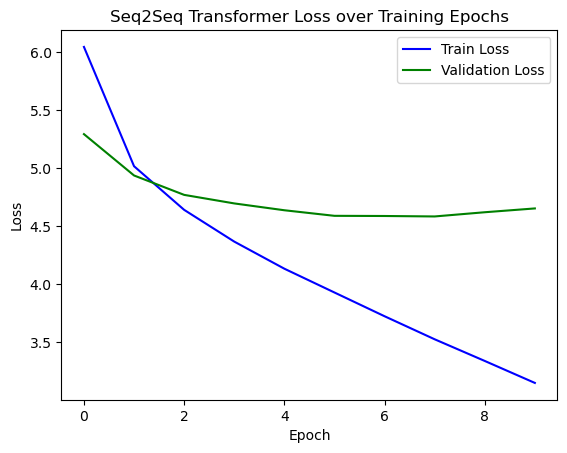

In [ ]:
results = pd.read_csv("training_results_20250511_234207.csv")

import matplotlib.pyplot as plt
plt.plot(results['train_loss'], label='Train Loss', color='blue')
plt.plot(results['val_loss'], label='Validation Loss', color='green')
plt.title('Seq2Seq Transformer Loss over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [216]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(8, 5))

    # Plot curves
    plt.plot(train_losses, label='Train Loss', color='royalblue', linewidth=2.5)
    plt.plot(val_losses, label='Validation Loss', color='seagreen', linewidth=2.5)

    # Style tweaks
    plt.title("Seq2Seq Transformer Loss over Epochs", fontsize=14, weight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=11)
    plt.tight_layout()

    # Optional: remove top/right borders
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

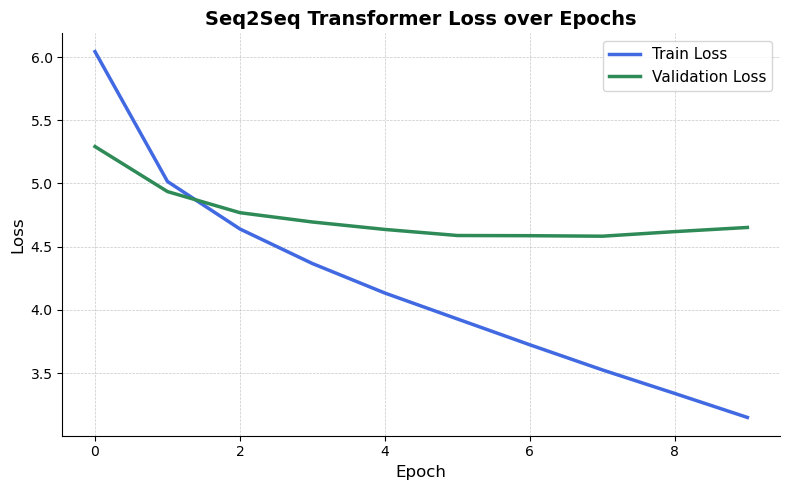

In [218]:
plot_loss(results['train_loss'], results['val_loss'])

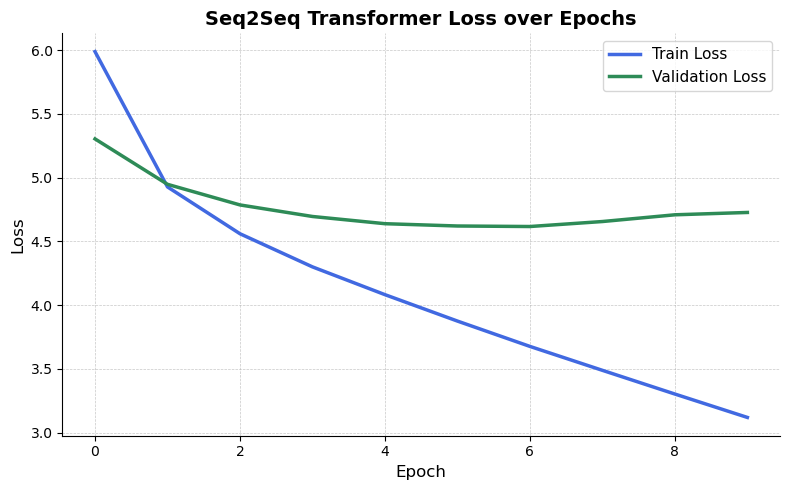

In [220]:
results_split = pd.read_csv("training_results_20250511_185336.csv")
plot_loss(results_split['train_loss'], results_split['val_loss'])